In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup as bs

In [2]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

In [3]:
def review_to_words(raw_review):
    #Convert the raw review string to a cleaner version taking the steps below
    #Why? So that sklearn's CountVectorizer will accept the review data as input
    
    #remove HTML
    review_text = bs(raw_review, "html.parser").get_text()
    
    #remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    #convert to lowercase and split into individual words
    words = letters_only.lower().split() 
    
    #convert stopwords to a set
    stops = set(stopwords.words("english"))  
    
    #remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    #join words back together
    #(this is just a long string of the words in the review)
    return " ".join(meaningful_words)

In [4]:
train_cleaned_articleBody = train['articleBody'].apply(review_to_words)
train_cleaned_headline = train['Headline'].apply(review_to_words)

test_cleaned_articleBody = test['articleBody'].apply(review_to_words)
test_cleaned_headline = test['Headline'].apply(review_to_words)

In [5]:
df = pd.concat([train_cleaned_articleBody,train_cleaned_headline], axis=1)
df = df.apply(lambda x: x[0]+' '+x[1], axis=1)

df_test = pd.concat([test_cleaned_articleBody, test_cleaned_headline], axis=1)
df_test = df_test.apply(lambda x: x[0]+' '+x[1], axis=1)

In [6]:
vectorizer = CountVectorizer(analyzer = 'word', #look at each word
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 5000) #only use 5000 words max

X_counts_raw = vectorizer.fit_transform(df)
vocab = vectorizer.get_feature_names() #all words present in the review data
vocab_size = len(vocab)

In [7]:
X_counts_raw_test = vectorizer.transform(df_test)

In [8]:
import sys
sys.getsizeof(X_counts_raw)

56

In [9]:
y_train = train['Stance'].apply(lambda x: 0 if x=='unrelated' else 1)
y_test = test['Stance'].apply(lambda x: 0 if x=='unrelated' else 1)

In [10]:
y_train

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
39875    0
39876    0
39877    0
39878    0
39879    0
39880    0
39881    0
39882    0
39883    0
39884    0
39885    0
39886    0
39887    0
39888    1
39889    0
39890    1
39891    1
39892    0
39893    0
39894    0
39895    0
39896    0
39897    1
39898    0
39899    0
39900    1
39901    1
39902    1
39903    1
39904    1
Name: Stance, dtype: int64

In [11]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Conv1D
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


In [13]:
MLP_input = Input(shape=[len(vocab)])
layer = Dense(vocab_size, kernel_initializer='glorot_normal')(MLP_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//32, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//64, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//128, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = Dense(1, kernel_initializer='glorot_normal')(layer)
out = Activation('sigmoid')(layer)

opt = Adam(lr=1e-4)
MLP = Model(MLP_input, out)
MLP.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.binary_accuracy])
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000)              20000     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 312)               1560312   
_________________________________________________________________
batch_normalization_2 (Batch (None, 312)               1248      
__________

In [14]:
hist=MLP.fit(X_counts_raw.todense(), y_train,
        epochs=100,
        batch_size=32,
        shuffle=True,
        verbose=2)

Epoch 1/100
48s - loss: 0.5507 - binary_accuracy: 0.7349
Epoch 2/100
47s - loss: 0.4198 - binary_accuracy: 0.8231
Epoch 3/100
47s - loss: 0.3841 - binary_accuracy: 0.8395
Epoch 4/100
46s - loss: 0.3597 - binary_accuracy: 0.8494
Epoch 5/100
46s - loss: 0.3413 - binary_accuracy: 0.8575
Epoch 6/100
46s - loss: 0.3238 - binary_accuracy: 0.8666
Epoch 7/100
46s - loss: 0.3070 - binary_accuracy: 0.8744
Epoch 8/100
46s - loss: 0.2905 - binary_accuracy: 0.8817
Epoch 9/100
46s - loss: 0.2765 - binary_accuracy: 0.8869
Epoch 10/100
46s - loss: 0.2628 - binary_accuracy: 0.8944
Epoch 11/100
46s - loss: 0.2536 - binary_accuracy: 0.8982
Epoch 12/100
45s - loss: 0.2373 - binary_accuracy: 0.9045
Epoch 13/100
45s - loss: 0.2274 - binary_accuracy: 0.9093
Epoch 14/100
45s - loss: 0.2192 - binary_accuracy: 0.9119
Epoch 15/100
45s - loss: 0.2077 - binary_accuracy: 0.9169
Epoch 16/100
44s - loss: 0.2033 - binary_accuracy: 0.9197
Epoch 17/100
45s - loss: 0.1959 - binary_accuracy: 0.9222
Epoch 18/100
46s - loss

In [15]:
import matplotlib.pyplot as plt

In [16]:
y_hat = MLP.predict(X_counts_raw_test.todense())

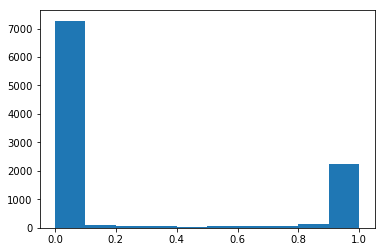

In [17]:
loss = hist.history['loss']
acc = hist.history['binary_accuracy']

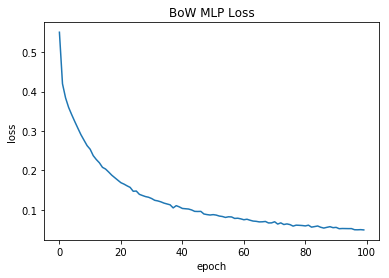

In [18]:
plt.plot(loss)
plt.title('BoW MLP Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('BoWMLPLoss.png')
plt.show()

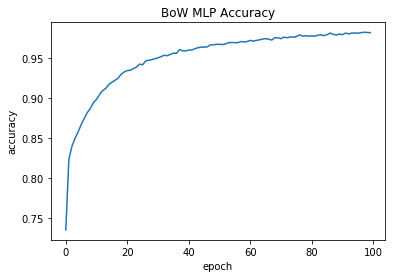

In [19]:
plt.plot(acc)
plt.title('BoW MLP Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('BoWMLPAcc.png')
plt.show()

In [20]:
y_hat = MLP.predict(X_counts_raw_test.todense())
test['BoWMLP']=y_hat
test.to_csv('BoWMLP.csv',index=False)

TypeError: `inputs` should be a list or tuple.

In [21]:
y_hat_classes = [round(i[0]) for i in y_hat]

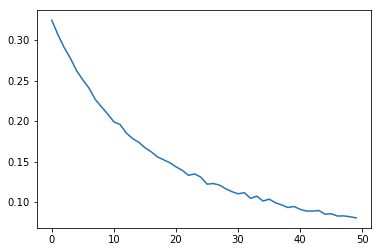

In [33]:
plt.plot(hist.history['loss'])
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
print(y_hat)

In [22]:
cutoff = 1e-20
while cutoff < 1:
    labels = y_hat > cutoff
    labels = [int(i) for i in labels]
    print(cutoff, accuracy_score(y_test, labels))
    cutoff = cutoff * 10

1e-20 0.268501043012
1e-19 0.268501043012
1e-18 0.268501043012
1e-17 0.268501043012
1.0000000000000001e-16 0.268501043012
1e-15 0.268501043012
1.0000000000000002e-14 0.268501043012
1.0000000000000002e-13 0.268501043012
1.0000000000000002e-12 0.268501043012
1.0000000000000001e-11 0.268501043012
1.0000000000000002e-10 0.268501043012
1.0000000000000003e-09 0.268600377471
1.0000000000000004e-08 0.271381742326
1.0000000000000004e-07 0.286182576736
1.0000000000000004e-06 0.343200556273
1.0000000000000004e-05 0.480580113241
0.00010000000000000005 0.668024237608
0.0010000000000000005 0.827456044502
0.010000000000000005 0.916658388795
0.10000000000000006 0.963842256879


In [52]:
y_hat_classes = y_hat < 0.9223
y_hat_classes = [int(i) for i in y_hat_classes]

[  1.00000000e+00   9.99999881e-01   9.99999762e-01   9.99999642e-01
   9.99999523e-01   9.99999404e-01   9.99999285e-01   9.99999166e-01
   9.99999046e-01   9.99998927e-01   9.99998808e-01   9.99998689e-01
   9.99998569e-01   9.99998450e-01   9.99998331e-01   9.99998212e-01
   9.99998093e-01   9.99997973e-01   9.99997854e-01   9.99997616e-01
   9.99997497e-01   9.99997377e-01   9.99997258e-01   9.99997139e-01
   9.99997020e-01   9.99996901e-01   9.99996781e-01   9.99996424e-01
   9.99996305e-01   9.99996185e-01   9.99996066e-01   9.99995947e-01
   9.99995828e-01   9.99995589e-01   9.99995351e-01   9.99995112e-01
   9.99994874e-01   9.99994755e-01   9.99994636e-01   9.99994516e-01
   9.99994278e-01   9.99993801e-01   9.99993682e-01   9.99993443e-01
   9.99993205e-01   9.99993086e-01   9.99992490e-01   9.99992371e-01
   9.99992251e-01   9.99992132e-01   9.99992013e-01   9.99991775e-01
   9.99991417e-01   9.99991298e-01   9.99991179e-01   9.99991059e-01
   9.99990940e-01   9.99990821e-01

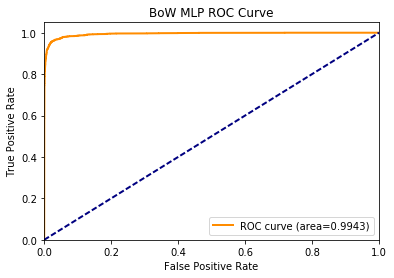

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_hat)

print(_)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BoW MLP ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc-auc-BoW-MLP-binary.png')
plt.show()

In [25]:
for cut in _:
    labels = y_hat > cut
    labels = [int(i) for i in labels]
    print(cut,accuracy_score(y_test, labels))

1.0 0.731498956988
1.0 0.735671004271
1.0 0.737558358995
1.0 0.738452369127
1.0 0.738651038045
0.999999 0.739147710341
0.999999 0.739346379259
0.999999 0.739644382636
0.999999 0.739843051555
0.999999 0.740439058309
0.999999 0.740836396146
0.999999 0.741333068441
0.999999 0.74153173736
0.999998 0.741829740737
0.999998 0.742525081951
0.999998 0.74262441641
0.999998 0.742823085328
0.999998 0.743121088706
0.999998 0.743220423165
0.999998 0.74381642992
0.999997 0.744114433297
0.999997 0.744511771133
0.999997 0.744611105593
0.999997 0.74490910897
0.999997 0.745008443429
0.999997 0.745306446806
0.999997 0.745703784643
0.999996 0.746597794775
0.999996 0.74719380153
0.999996 0.747392470448
0.999996 0.747789808284
0.999996 0.747988477203
0.999996 0.74828648058
0.999996 0.748584483957
0.999995 0.748882487335
0.999995 0.748981821794
0.999995 0.74947849409
0.999995 0.749677163008
0.999995 0.750074500844
0.999995 0.750273169763
0.999994 0.750769842058
0.999994 0.75166385219
0.999994 0.751862521109
0

In [26]:
labels = y_hat > 0.550552
labels = [int(i) for i in labels]

In [28]:
test['BoWMLP']=labels
test.to_csv('BoWMLPBinary.csv',index=False)

In [30]:
print(confusion_matrix(y_test, labels))
accuracy_score(y_test, labels)

0.97208701698619249